In [2]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP,LinearAlgebra
PythonPlot.svg(true)
include("model.jl")

FIG_PATH = "/Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/cell-size/linear_model/figures"

"/Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/cell-size/linear_model/figures"

In [47]:

dt = 0.01
T = 4000
init = [0.0, 0.0, 0.0, 0.0]
vz = 0.01
ν0 = 1/log(2)



q_range = collect(0.0:0.05:1.0)
T_range = collect(50:5:400)
ω0 = 0.01
η = 0.05
c = 0.
q = 0.9
#dfs = []
dfs = []

for T in T_range
    a = ω0*η
    
    σ = sqrt(vz*a*ω0^2) # variance of noise in z
    params = build_model2d(a,a,ω0,q,σ,c)
    df = make_sim_df(init, params, dt, T)

    df.y = df.z .+ log(2) .* df.θ .+ rand(Normal(0,0.0002), size(df,1))
    dfcell_sim = combine(groupby(df, :cell),
            :z => first => :z0,
            :y => (x -> x[end] - x[1]) => :ϕ,
            :time => (x -> x[end] - x[1]) => :τ,
            :x1 => mean => :x1,
            :x2 => mean => :x2,
            [:y, :time] => ((y, t) -> begin
                # Compute regression coefficient β = Cov(t,y) / Var(t)
                t_mean = mean(t)
                y_mean = mean(y)
                cov_ty = mean((t .- t_mean) .* (y .- y_mean))
                var_t = mean((t .- t_mean).^2)
                var_t > 0 ? cov_ty / var_t : 0.0
            end) => :β)
    dfcell_sim.λ = dfcell_sim.ϕ ./dfcell_sim.τ

    dfcell_sim.q .= q
    dfcell_sim.T .= T
    df.q .= q
    df.ω0 .= ω0
    df.η .= η
    dfcell_sim.ω0 .= ω0
    dfcell_sim.η .= η
    dfcell_sim.c .= c
    dfcell_sim.isphys .=  isphysical(df)
    #push!(dfs,df)
    push!(dfs,dfcell_sim)
end



#dfs = vcat(dfs...);
dfs = vcat(dfs...);

dfα = combine(groupby(dfs, :T), [:λ, :z0,:τ] => ((λ, z0, τ) -> cov(λ,z0)/var(z0)*mean(τ)) => :αλ1,
[:β, :z0,:τ] => ((β, z0, τ) -> cov(β,z0)/var(z0)*mean(τ)) => :αλ2);
# Save

Row,T,αλ1,αλ2
,Int64,Float64,Float64
1,50,-0.0267096,-0.00617148
2,55,-0.0220367,-0.0172447
3,60,0.00451707,-0.00347129
4,65,-0.0190842,-0.0463523
5,70,NaN,-19.7399
6,75,-0.0167949,-0.00219258
7,80,0.01223,0.0138006
8,85,-0.00329195,0.0134259
9,90,0.0121973,0.0105211


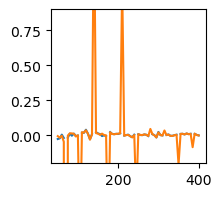

In [48]:
fig,ax = subplots(figsize=(2,2))
ax.plot(T_range, dfα.αλ1, "-")
ax.plot(T_range, dfα.αλ2, "-")
#ax.plot([-.01,0.01],[-0.01,0.01],"k--")
ax.set_ylim([-0.2,0.9])
fig